In [1]:
##Import packages

import subprocess
import numpy as np
import os, sys, shutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import pandas as pd
import gc
import math
import time

from sklearn.cluster import KMeans

%matplotlib notebook

In [2]:
## Identify all water molecules
def distance(box, atom, aim_pool):
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    return distance
def findNearest(box, atom, aim_pool, num):
    """
    Find the nearest one to given atom from a group of candidate
    Input: 
        box: periodic box size
        atom: given atom (position, dimention=3d)
        aim pool: a list of positions.
    Return:
        index of closest atom in aim_pool
    
    """
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    sorted_dis = sorted(distance)
    res = np.where(distance <= sorted_dis[num])[0]
    if len(res)>num:
        res = np.concatenate((np.where(distance < sorted_dis[num])[0],np.where(distance == sorted_dis[num])[0]))
        res = res[:num]
    return res

In [3]:
def get_O_in_OH(atoms_lines, box):
    
    pos = [[float(_e) for _e in e.split()] for e in atoms_lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
    
    Os = atoms[np.where(atoms[:,0]=='O')[0],1:]
    Hs = atoms[np.where(atoms[:,0]=='H')[0],1:]

    dis_mat = np.zeros((len(Hs), len(Os)))
    for i in range(len(Hs)):
        dis_mat[i] = distance(box, Hs[i], Os)
    dis = np.array([np.where(e == min(e))[0][0] for e in dis_mat])
    return dis

In [4]:
def _if_bond_(lines, Os, Hs, box):
    
    OH_cutoff = 1.28
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    for i in range(len(box)):
        pos[:,i] = pos[:,i]*box[i]
    
    i = 0
    l = []
    ang = []
    
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec

    def __angle(vec1, vec2):
        a = vec1/np.linalg.norm(vec1)
        b = vec2/np.linalg.norm(vec2)
        temp = np.dot(vec1, vec2)
        if temp>1:
            temp=1
        if temp<-1:
            temp=-1
        return math.acos(temp)
    
    while i < len(Os):
        _O = Os[i]
        _num = np.count_nonzero(Os == _O, axis=0)
        vec = []
        for j in range(_num):
            _i = i+j 
            _temp = np.linalg.norm(__periodic(pos[Hs[_i]]-pos[Os[_i]],box))
            if _temp <= OH_cutoff:
                l.append(1)
                vec.append(1)
            else:
                l.append(0)
                vec.append(0)
        if _num > 1:
            temp = np.zeros((_num,_num))
            for _i in range(_num):
                for _j in range(_i+1,_num):
                    ang.append(vec[_i]*vec[_j])
        i=i+_num
    return np.array(l), np.array(ang)
                    
        

In [5]:
def bond_angle(lines, Os, Hs, box):
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    for i in range(len(box)):
        pos[:,i] = pos[:,i]*box[i]
    
    i = 0
    l = []
    ang = []
    
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec

    def __angle(vec1, vec2):
        a = vec1/np.linalg.norm(vec1)
        b = vec2/np.linalg.norm(vec2)
        temp = np.dot(vec1, vec2)
        if temp>1:
            temp=1
        if temp<-1:
            temp=-1
        return math.acos(temp)
    
    while i < len(Os):
        _O = Os[i]
        _num = np.count_nonzero(Os == _O, axis=0)
        vec = []
        for j in range(_num):
            _i = i+j
            vec.append(__periodic(pos[Hs[_i]]-pos[Os[_i]],box)) 
            l.append(np.linalg.norm(vec[-1]))
        if _num > 1:
            temp = np.zeros((_num,_num))
            for _i in range(_num):
                for _j in range(_i+1,_num):
                    ang.append(__angle(vec[_i],vec[_j]))
        i=i+_num
    return np.array(l), np.array(ang)

In [6]:
def water_form(lines, eles, box, res_type = 'idxs'):
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
        
    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    Pinds = np.where(atoms[:,0]=='P')[0]

    Os = atoms[Oinds,1:]
    Hs = atoms[Hinds,1:]
    Ps = atoms[Pinds,1:]

    OH_cutoff = 1.28
    O_H_cutoff = 2.25   
        
    mol = []
    for i in range(len(Os)):
        temp_OH = distance(box, Os[i], Hs)
        OH_idx = np.where(temp_OH<OH_cutoff)[0]
        No_OH = len(OH_idx)
        No_O_H = len(np.where(temp_OH<O_H_cutoff)[0]) - No_OH
        t = []
        t.append(No_OH)
        t.append(No_O_H)
        doner_H = 0
        #print(i)
        for _H in OH_idx:
            temp_HO = distance(box, Hs[_H], Os)
            #print(sorted(temp_HO))
            temp_HO = np.where(temp_HO<O_H_cutoff)[0]
            doner_H += (len(temp_HO)-1)
        #print(doner_H)
        t.append(doner_H)
        mol.append(t)
    mol = np.array(mol,dtype='object')
    
    mol_type = ['']*len(Os)
    for i, wat in enumerate(mol):
        temp = ''
        if wat[0] == 3:
            temp = temp+'hydronium'
            if wat[1] == 0 and wat[2] == 3:
                temp = temp+'-AAA'
            else:
                temp = temp+'-exception'
        elif wat[0] == 2:
            temp = temp+'water'
            if wat[2] > 0:
                temp = temp+'-'+'D'*wat[2]
            if wat[1] > 0:
                temp = temp+'A'*wat[1]
        else:
            temp = '-O'
            if wat[0]>0:
                temp = temp+'H'
            temp = temp+' in H3PO4'
        if res_type == 'idxs':
            if temp not in mol_type_class:
                mol_type[i] = 5
            else:
                mol_type[i] = mol_type_class[temp]
        else:
            mol_type[i] = temp
        
    return mol_type

In [7]:
def water_form_lifetime(mol_type_time, water_form_idx = -1, water_form = 'water-DDAA'):
    
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    if water_form_idx == -1:
        form_idx = mol_type_class[water_form]
    else:
        form_idx = water_form_idx
    periods = []
    periods_statis = []
    for i in range(len(mol_type_time[0])):
        l = mol_type_time[:,i]
        _start=0
        _end = 0
        _if = 0
        _periods = []
        for _i, e in enumerate(l):
            if e == form_idx:
                if _if == 0:
                    _start = _i
                    _if=1
                if _if == 1:
                    _end = _i
            if e != form_idx:
                if _if == 1:
                    _period = _end - _start
                    _if=0
                    if _period > 50:
                        _periods.append([_start,_end])
                        periods_statis.append(_end - _start)
            #print(_start,_end,_if,e)
        if _if == 1:
            _period = _end - _start
            if _period > 50:
                _periods.append([_start,_end])
                periods_statis.append(_end - _start)
        #print(i,_periods)
        periods.append(_periods)
    return periods, periods_statis

In [8]:
from scipy.interpolate import make_interp_spline, BSpline

def R_k(rlist, k):
    l=len(rlist)
    working_l = np.concatenate((rlist,rlist[:k]))
    mu = np.average(working_l)
    s = np.std(working_l,ddof=1)
    working_l = (working_l-mu)/s
    res = 0
    for i in range(l):
        res+=working_l[i]*working_l[i+k]
    res = res/l
    return res
def get_freq(rlist, k):
    ts = 0.5 #fs
    l = []
    ks = np.arange(k)
    for _k in ks:
        l.append(R_k(rlist,_k))
    ks = ks*ts
    
    knew = np.linspace(ks.min(), ks.max(), 300) 
    spl = make_interp_spline(ks, l, k=5)
    l_smooth = spl(knew)
    '''
    plt.plot(ks, l)
    plt.plot(knew, l_smooth)
    plt.show()
    '''
    freq = 0
    for i in range(1,len(l_smooth)-1):
        if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
            if knew[i] >= 2:
                freq = knew[i]
                break
    if freq == 0:
        return 0, np.average(rlist)
    return np.sqrt(17/9)/freq, np.average(rlist)

from scipy.fftpack import fft, dct

def get_freq_fft(rlist, k):
    ts = 0.5 #fs
    l = []
    ks = np.arange(k)
    for _k in ks:
        l.append(R_k(rlist,_k))
    ks = ks*ts
    l = dct(rlist)[:k]
    knew = np.linspace(ks.min(), ks.max(), 300) 
    spl = make_interp_spline(ks, l, k=5)
    l_smooth = spl(knew)
    '''
    plt.plot(ks, l)
    plt.plot(knew, l_smooth)
    plt.show()
    '''
    freq = 0
    for i in range(1,len(l_smooth)-1):
        if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
            if knew[i] >= 2:
                freq = knew[i]
                break
    if freq == 0:
        return 0, np.average(rlist)
    return np.sqrt(17/9)/freq, np.average(rlist)

In [9]:
def vib_info(sys_ind,Tem,water_form = 'water-DDAA'):
    outfile = sys_ind+'/'+Tem+"_O_form.npy"
    mol_type_time = np.load(outfile)

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds.npy")
    

    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg.npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg.npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH.npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH.npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _bondL[:,_i].T:
                _a,_b = get_freq(l, 50)
                bond_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                _a,_b = get_freq(l, 50)
                angle_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
    return np.array(bond_mat), np.array(angle_mat)
def vib_info_fft(sys_ind,Tem,water_form = 'water-DDAA'):
    outfile = sys_ind+'/'+Tem+"_O_form.npy"
    mol_type_time = np.load(outfile)

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds.npy")
    

    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg.npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg.npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH.npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH.npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _bondL[:,_i].T:
                _a,_b = get_freq_fft(l, 50)
                bond_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                _a,_b = get_freq_fft(l, 50)
                angle_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
    return np.array(bond_mat), np.array(angle_mat)

In [10]:
import subprocess

def energyVStime(data_path, filename, s_type = 'dft', timestep = 0.1):
    if s_type == 'dft':
        bashCommand = "grep ' E=' " + os.path.join(data_path, filename)
        lines = subprocess.check_output(bashCommand, shell=True)
        lines = str(lines)[2:].split('\\n')[:-1]
        lines = [[e.split()[0], e.split()[2],e.split()[4]]for e in lines]
        lines = np.array([[float(e) for e in l] for l in lines])
        y = lines[:,2]
        x = lines[:,0]
        n = max( len(lines[:,0])//5, 500 )
        s = (np.average(y[-n-50:-n])-np.average(y[-(1+50):-1]))/(x[-n]-x[-1]) * 0.995
        #s = (y[0]-y[-1])/(x[0]-x[-1])
        y = y - (s * (x-x[-1]))
    if s_type == 'dft2':
        bashCommand = "grep ' entropy=' " + os.path.join(data_path, filename)
        lines = subprocess.check_output(bashCommand, shell=True)
        lines = str(lines)[2:].split('\\n')[:-1]
        lines = [float(e.split()[3])for e in lines]
        return lines
        
    elif s_type == 'lmp':
        with open(os.path.join(data_path,filename)) as f:
            lines = f.readlines()
            lines = [line.split() for line in lines if len(line.split())==9]
            temp = []
            for line in lines:
                try:
                    temp_line = []
                    temp_line.append(int(line[0]))
                    for e in line[1:]:
                        temp_line.append(float(e))
                    temp.append(temp_line)
                except:
                    continue
            lines = np.array(temp)
        x = lines[1:,0]*timestep
        y = lines[1:,3]
    else:
        print('simulation type not implemented')
        return None, None
    plt.scatter(x,y)
    return x,y

In [11]:
import subprocess

def pressureVStime(data_path, filename):
    if True:
        bashCommand = "grep 'total pressure' " + os.path.join(data_path, filename)
        lines = subprocess.check_output(bashCommand, shell=True)
        lines = str(lines)[2:].split('\\n')[:-1]
        lines = [float(e.split()[-2]) for e in lines]
    return lines

In [ ]:
pressure_y = pressureVStime('/rhome/wzhan097/bigdata/LiCl_testRun/_history', 'OUTCAR02')
plt.plot(pressure_y) #kB
# 5ps done in 
plt.plot(running_mean(pressure_y,200))
plt.ylim(-10,10)

In [ ]:
pressure_y = pressureVStime('/rhome/wzhan097/bigdata/LiCl_testRun_RT/_history', 'OUTCAR02')
plt.plot(pressure_y)
plt.plot(running_mean(pressure_y,200))
# reduce volume by 14.5 - 0.01 (small change to check ) (E-4) (LT)
plt.ylim(-10,10)

In [ ]:
## Example structure
#### read structure
#data_path = '/bigdata/greaneylab/wzhan097/whoochul'
data_path = '/bigdata/greaneylab/wzhan097/woochul'
filename = 'H3PO4_lowT_20ps.vasp'

Tem = 'LT'
sys_ind = '06'
Tem_tag = '' #'_RT' for RT

if Tem == 'RT':
    Tem_tag = '_RT'
data_path = '/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp'+Tem_tag+'/'+sys_ind
filename = 'XDATCAR'


with open(os.path.join(data_path,filename),'r') as f:
    lines = f.readlines()
box = lines[2:5]
box =[e.split() for e in box]
box = [box[0][0],box[1][1],box[2][2]]
box = [float(e) for e in box]
lines = lines[5:]
types = lines[0].split()
temp = lines[1].split()
temp = [int(e) for e in temp]
eles = []
atom_num = sum(temp)

for _i,_j in zip(types, temp):
    eles = eles+[[_i]]*_j
eles = np.array(eles, dtype = 'object')
lines = lines[2:]

In [ ]:
####The formation of water is changing

O_H_mat = np.zeros((atom_num, atom_num))

pos = [[float(_e) for _e in e.split()] for e in lines[1:1+atom_num]]
pos = np.array(pos, dtype = 'object')
atoms = np.concatenate((eles, pos),axis=1)

for i in range(len(box)):
    atoms[:,i+1] = atoms[:,i+1]*box[i]

Oinds = np.where(atoms[:,0]=='O')[0]
Hinds = np.where(atoms[:,0]=='H')[0]

for i in range( 0,int(len(lines)/(atom_num+1)) ):
    temp = get_O_in_OH(lines[i*(atom_num+1):(i+1)*(atom_num+1)],box)
    for _i, _j in enumerate(temp):
        O_H_mat[Oinds[_j], Hinds[_i]]+=1
    if i%500 == 0:
        print(i)

In [ ]:
temp_tag = '_01'

In [ ]:
bond_Os, bond_Hs = np.where(O_H_mat!=0)
bond_l = len(bond_Os)
bond_a = 0
for _O in set(bond_Os):
    bond_a += sum(list(range(np.count_nonzero(bond_Os == _O, axis=0))))
bond_l = np.zeros(((int(len(lines)/(atom_num+1))), bond_l))
bond_a = np.zeros(((int(len(lines)/(atom_num+1))), bond_a))
for i in range( 0,int(len(lines)/(atom_num+1)) ):
    _x,_y = bond_angle(lines[i*(atom_num+1):(i+1)*(atom_num+1)], bond_Os, bond_Hs, box)
    bond_l[i] = _x
    bond_a[i] = _y
    if i%500 == 0:
        print(i)
outfile = sys_ind+'/'+Tem+"_OH"+'_01'+".npy"
np.save(outfile,bond_l)
outfile = sys_ind+'/'+Tem+"_HOH"+'_01'+".npy"
np.save(outfile,bond_a)

In [ ]:
bond_Os, bond_Hs = np.where(O_H_mat!=0)
bond_l = len(bond_Os)
bond_a = 0
for _O in set(bond_Os):
    bond_a += sum(list(range(np.count_nonzero(bond_Os == _O, axis=0))))
bond_l = np.zeros(((int(len(lines)/(atom_num+1))), bond_l))
bond_a = np.zeros(((int(len(lines)/(atom_num+1))), bond_a))
for i in range( 0,int(len(lines)/(atom_num+1)) ):
    _x,_y = _if_bond_(lines[i*(atom_num+1):(i+1)*(atom_num+1)], bond_Os, bond_Hs, box)
    bond_l[i] = _x
    bond_a[i] = _y
    if i%500 == 0:
        print(i)
outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
np.save(outfile,bond_l)
outfile = sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
np.save(outfile,bond_a)

In [ ]:
mol_type_time = np.zeros((int(len(lines)/(atom_num+1)), len(np.where(eles=='O')[0])))
for i in range( 0,int(len(lines)/(atom_num+1)) ):
    temp = water_form(lines[i*(atom_num+1):(i+1)*(atom_num+1)], eles, box)
    mol_type_time[i] = temp
    if i%500 == 0:
        print(i)
outfile = sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
np.save(outfile,mol_type_time)
outfile = sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy"
np.save(outfile,bond_Os)

In [ ]:
sys_ind = '02'
Tem = 'RT'
temp_tag = '_01'

outfile = sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)
fig,_ = plt.subplots(2, 2)
fig.suptitle(sys_ind+'/'+Tem)

_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDAA')
ax1 = plt.subplot(221)
ax1.hist(periods_statis,bins=50)
ax1.set_title('water-DDAA')
#ax1.set_xlabel('lifetime(timestep)')
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'hydronium-AAA')
ax2 = plt.subplot(222)
ax2.hist(periods_statis,bins=50)
ax2.set_title('hydronium-AAA')
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(212)
ax3 = sns.heatmap(mol_type_time.T[70:,-2000:],cmap='RdBu_r')
plt.show()

In [ ]:
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DDAA')
sns.kdeplot(data=periods_statis)

In [ ]:
_,periods_statis = water_form_lifetime(mol_type_time[-5000:], water_form = 'water-DAA')
sns.kdeplot(data=periods_statis)

In [ ]:
form_count = [0]*8
for i in range(len(mol_type_time) - 100, len(mol_type_time)):
    for _i in range(8):
        form_count[_i] += len(np.where(mol_type_time[i,:]==_i)[0])/100.0
df = pd.DataFrame(data=[form_count], 
                  index = [sys_ind+'/'+Tem],
                  columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                           'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                           '-O in H3PO4'])

df_water_form_num = df
df_water_form_num = df_water_form_num.append(df)
df_water_form_num

In [ ]:
temp = []
for i in range(8):
    _,_temp = water_form_lifetime(mol_type_time[-5000:], water_form_idx = i)
    temp.append(np.average(_temp))
df = pd.DataFrame(data=[temp], 
                  index = [sys_ind + '/' + Tem], 
                  columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                           'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                           '-O in H3PO4'])

#df_water_form_lifetime = df
df_water_form_lifetime = df_water_form_lifetime.append(df)
df_water_form_lifetime

In [ ]:
mol_type_time.shape

In [ ]:
sys_ind = '00'
Tem = 'LT'
water_form = 'hydronium-AAA'
temp_b,temp_a = vib_info(sys_ind, Tem, water_form = water_form)
fig,_ = plt.subplots(2, 1, figsize = (12, 12))
fig.suptitle(sys_ind + '/' + Tem + ', ' + water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1], bins = 25)
ax1.set_title(water_form + '-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2], bins = 25)
ax2.set_title(water_form + '-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1], bins = 25)
ax3.set_title(water_form + '-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2], bins = 25)
ax4.set_title(water_form + '-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'LT'
water_form = 'water-DDA'
temp_b,temp_a = vib_info(sys_ind, Tem, water_form = water_form)
fig,_ = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle(sys_ind + '/' + Tem + ', ' + water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1],bins = 25)
ax1.set_title(water_form + '-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2],bins = 25)
ax2.set_title(water_form + '-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1],bins = 25)
ax3.set_title(water_form + '-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2],bins = 25)
ax4.set_title(water_form + '-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'RT'
water_form = 'hydronium-AAA'
temp_b,temp_a = vib_info(sys_ind, Tem, water_form = water_form)
fig,_ = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle(sys_ind + '/' + Tem + ', ' + water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1],bins = 25)
ax1.set_title(water_form + '-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2],bins = 25)
ax2.set_title(water_form + '-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1],bins = 25)
ax3.set_title(water_form + '-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2],bins = 25)
ax4.set_title(water_form + '-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'RT'
water_form = 'water-DDA'
temp_b,temp_a = vib_info(sys_ind,Tem,water_form=water_form)
fig,_ = plt.subplots(2, 1,figsize=(12, 12))
fig.suptitle(sys_ind+'/' + Tem + ', ' +water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1],bins = 25)
ax1.set_title(water_form+'-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2],bins = 25)
ax2.set_title(water_form+'-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1],bins = 25)
ax3.set_title(water_form+'-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2],bins = 25)
ax4.set_title(water_form+'-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'LT'
water_form = 'hydronium-AAA'
temp_b,temp_a = vib_info_fft(sys_ind, Tem, water_form = water_form)
fig,_ = plt.subplots(2, 1, figsize = (12, 12))
fig.suptitle(sys_ind + '/' + Tem + ', ' + water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1], bins = 25)
ax1.set_title(water_form + '-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2], bins = 25)
ax2.set_title(water_form + '-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1], bins = 25)
ax3.set_title(water_form + '-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2], bins = 25)
ax4.set_title(water_form + '-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'LT'
water_form = 'water-DDA'
temp_b,temp_a = vib_info_fft(sys_ind, Tem, water_form = water_form)
fig,_ = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle(sys_ind + '/' + Tem + ', ' + water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1],bins = 25)
ax1.set_title(water_form + '-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2],bins = 25)
ax2.set_title(water_form + '-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1],bins = 25)
ax3.set_title(water_form + '-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2],bins = 25)
ax4.set_title(water_form + '-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'RT'
water_form = 'hydronium-AAA'
temp_b,temp_a = vib_info_fft(sys_ind, Tem, water_form = water_form)
fig,_ = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle(sys_ind + '/' + Tem + ', ' + water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1],bins = 25)
ax1.set_title(water_form + '-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2],bins = 25)
ax2.set_title(water_form + '-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1],bins = 25)
ax3.set_title(water_form + '-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2],bins = 25)
ax4.set_title(water_form + '-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
sys_ind = '00'
Tem = 'RT'
water_form = 'water-DDA'
temp_b,temp_a = vib_info_fft(sys_ind,Tem,water_form=water_form)
fig,_ = plt.subplots(2, 1,figsize=(12, 12))
fig.suptitle(sys_ind+'/' + Tem + ', ' +water_form)

ax1 = plt.subplot(221)
ax1.hist(temp_b[:,1],bins = 25)
ax1.set_title(water_form+'-bond vib freq, ave = ' + str(np.average(temp_b[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax2 = plt.subplot(222)
ax2.hist(temp_b[:,2],bins = 25)
ax2.set_title(water_form+'-bond length, ave = ' + str(np.average(temp_b[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(223)
ax3.hist(temp_a[:,1],bins = 25)
ax3.set_title(water_form+'-angle vib freq, ave = ' + str(np.average(temp_a[:,1])))
#ax1.set_xlabel('lifetime(timestep)')
ax4 = plt.subplot(224)
ax4.hist(temp_a[:,2],bins = 25)
ax4.set_title(water_form+'-angle, ave = ' + str(np.average(temp_a[:,2])))
#ax2.set_xlabel('lifetime(timestep)')
plt.show()

In [ ]:
data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/LT/2case/lammps_longer'
filename = 'log.lammps'
x,y = energyVStime(data_path, filename, s_type = 'lmp',timestep = 0.0001)
y = y*0.043
plt.close()
plt.scatter(x,y,s=2)
plt.plot(running_mean(x, 20),running_mean(y, 20),color = 'r')
plt.xlabel('Time (ps)')
plt.ylabel('Energy (eV/atom)')
plt.title('MD simulation')
#3 ns
plt.show()

In [ ]:
plt.scatter(x,y,s=2,label = 'Potential Energy')
plt.plot(running_mean(x, 500),running_mean(y, 500),color = 'r',label = 'Running Mean')
plt.xlabel('Time (ps)')
plt.ylabel('Energy (eV/atom)')
plt.ylim(-3720, -3650)
plt.legend()
plt.show()

In [ ]:
X, Y = running_mean(x, 2500),running_mean(y, 2500)
(Y[-1]-Y[500])/X[-1]-X[500]

In [ ]:
X[-1]-X[20]

In [12]:
def running_mean(_y, N):
    cumsum = np.cumsum(np.insert(_y, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
plt.plot(running_mean(x, 50)[-3500:],running_mean(y, 50)[-3500:])

In [58]:
y = energyVStime('/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/LT/2case/dft/_history', 'OUTCAR01',s_type = 'dft2')
y2 = energyVStime('/rhome/wzhan097/bigdata/LiCl_testRun/_history', 'OUTCAR02',s_type = 'dft2')
y3 = energyVStime('/rhome/wzhan097/bigdata/LiCl_testRun/_history', 'OUTCAR03',s_type = 'dft2')
y4 = energyVStime('/rhome/wzhan097/bigdata/LiCl_testRun', 'OUTCAR',s_type = 'dft2')
y_LT  = np.concatenate((y[:],np.array(y2), np.array(y3), np.array(y4)))

In [100]:
y = energyVStime('/rhome/wzhan097/bigdata/proton_battery/LiCl/25p_mass/RT/2case/dft/_history', 'OUTCAR01',s_type = 'dft2')
y2 = energyVStime('/rhome/wzhan097/bigdata/LiCl_testRun_RT/_history', 'OUTCAR02',s_type = 'dft2')
y3 = energyVStime('/rhome/wzhan097/bigdata/LiCl_testRun_RT/_history', 'OUTCAR03',s_type = 'dft2')
y4 = energyVStime('/rhome/wzhan097/bigdata/LiCl_testRun_RT', 'OUTCAR',s_type = 'dft2')
y_RT = np.concatenate((y,np.array(y2),np.array(y3), np.array(y4), np.array(y4)))

In [66]:
y_LT.shape, y_RT.shape

((35325,), (36728,))

In [105]:
y_RT-y_RT[0],y_LT[0]

(-1451.07674174, -1456.78202245)

(-0.042, 0.003)

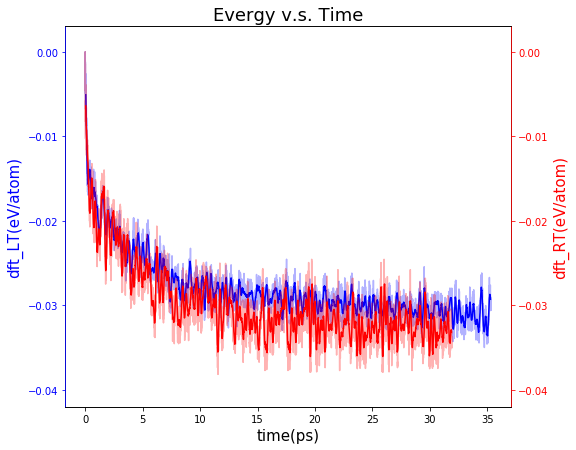

In [118]:
fig,ax_LT = plt.subplots(figsize = (8,7))
plt.title('Evergy v.s. Time',fontsize=18)
ax_RT = ax_LT.twinx()
_x = np.array(range(len(y_RT)))/1000
_y = (y_RT-max(y_RT))/302
ax_RT.plot(_x,_y, label = 'dft_RT', color = 'r',alpha = 0.3)
ax_RT.plot(running_mean(_x, 100),running_mean(_y, 100), label = 'dft_RT', color = 'r')


_x = np.array(range(len(y_LT)))/1000
_y = (y_LT-max(y_LT))/302
ax_LT.plot(_x,_y, label = 'dft_LT', color = 'b',alpha = 0.3)
ax_LT.plot(running_mean(_x, 100),running_mean(_y, 100), label = 'dft_LT', color = 'b')


ax_LT.set_xlabel('time(ps)',fontsize=15)
ax_LT.set_ylabel('dft_LT(eV/atom)', color = 'b',fontsize=15)
ax_RT.spines['left'].set_color('blue')
ax_LT.tick_params(axis='y',colors='blue')
ax_RT.set_ylabel('dft_RT(eV/atom)', color = 'r',fontsize=15)
ax_RT.tick_params(axis='y',colors='red')
ax_RT.spines['right'].set_color('red')
ax_RT.set_ylim((-0.042,0.003))
ax_LT.set_ylim((-0.042,0.003))
#plt.legend()

In [ ]:
plt.plot(np.array(range(len(y_LT)))/1000,(y_LT-y_LT[0]), label = 'dft_LT', color = 'b')

In [ ]:
plt.plot()

In [ ]:
y[int(len(lines[:,0]/100))], y[-1]

In [ ]:
sys_ind = '00'
Tem = 'LT'
temp_tag = ''

outfile = sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)

test_data,_ = water_form_lifetime(mol_type_time[:], water_form = 'water-DDAA')

In [ ]:
outfile = sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
temp_bond = np.load(outfile)
temp_bond

In [ ]:
test_data[100][0], test_data[94][4]

In [ ]:
outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
temp_flg = np.load(outfile)
temp_flg

In [ ]:
outfile = sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy"
O_inds = np.load(outfile)
np.where(O_inds==100)

In [ ]:
temp_flg[155]

In [ ]:
12.5

92 water molecules and 13 Li atoms and 13 

In [ ]:
vol = 1.25e-7**3 #cm^3
c_NA = 6.22e23
mass = 92*18.01528/c_NA + 13*42.394/c_NA
mass/vol